<a href="https://colab.research.google.com/github/janamoumita1997/Leaf_and_skin_Disease_classification/blob/main/leaf_disease_using_resnet50_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#IMPORTING LIBRARIES
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [ ]:
import tensorflow
from tensorflow import keras
from keras.models import Sequential,load_model,Model
from keras.layers import Conv2D,MaxPool2D,AveragePooling2D,Dense,Flatten,ZeroPadding2D,BatchNormalization,Activation,Add,Input,Dropout,GlobalAveragePooling2D
from keras.optimizers import SGD
from keras.initializers import glorot_uniform
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/skin_plant_disease/dataset/skin_plant_disease.zip" -d"/content"

unzip:  cannot find or open /content/drive/MyDrive/skin_plant_disease/dataset/skin_plant_disease.zip, /content/drive/MyDrive/skin_plant_disease/dataset/skin_plant_disease.zip.zip or /content/drive/MyDrive/skin_plant_disease/dataset/skin_plant_disease.zip.ZIP.


In [ ]:
# !pip install opendatasets

In [ ]:
# import opendatasets as od
# import pandas

# od.download(
# 	"https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset/download?datasetVersionNumber=2")

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

In [ ]:
base_model_tf=ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),classes=5)

94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
#Model building
base_model_tf.trainable=False

pt=Input(shape=(224,224,3))
func=tensorflow.cast(pt,tensorflow.float32)
x=preprocess_input(func) #This function used to zero-center each color channel wrt Imagenet dataset
model_resnet=base_model_tf(x,training=False)
model_resnet=GlobalAveragePooling2D()(model_resnet)
model_resnet=Dense(128,activation='relu')(model_resnet)
model_resnet = Dropout(0.4)(model_resnet)
model_resnet=Dense(64,activation='relu')(model_resnet)
model_resnet = Dropout(0.4)(model_resnet)
model_resnet=Dense(5,activation='softmax')(model_resnet)


model_main=Model(inputs=pt,outputs=model_resnet)
model_main.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.cast (TFOpLambda)        (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                      

In [ ]:
#Image augmentation
# train_datagen= ImageDataGenerator(shear_range=0.2,zoom_range=0.2,horizontal_flip=False,vertical_flip=False
#                                   ,fill_mode='nearest',width_shift_range=0.2,height_shift_range=0.2)

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   rotation_range=15,
                                   vertical_flip=True,
                                   fill_mode='reflect',
                                   data_format='channels_last',
                                   brightness_range=[0.5, 1.5])
val_datagen = ImageDataGenerator(rescale = 1./255)

path_train='/content/skin_plant_disease/train'

path_valid='/content/skin_plant_disease/validation'

train= train_datagen.flow_from_directory(directory=path_train,batch_size=32,target_size=(224,224),
                                         color_mode='rgb',class_mode='sparse',seed=42)

valid=val_datagen.flow_from_directory(directory=path_valid,batch_size=32,target_size=(224,224),color_mode='rgb',class_mode='sparse')

Found 5065 images belonging to 5 classes.
Found 1161 images belonging to 5 classes.


In [ ]:
#CallBacks
es=EarlyStopping(monitor='sparse_categorical_accuracy',verbose=1,patience=7,mode='auto')
mc=ModelCheckpoint(filepath='/content',monitor='sparse_categorical_accuracy',verbose=1,save_best_only=True)
lr=ReduceLROnPlateau(monitor='sparse_categorical_accuracy',verbose=1,patience=5,min_lr=0.01)    #val_accuracy

In [ ]:
# model_main.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model_main.compile(
            optimizer='Adam',
            loss='sparse_categorical_crossentropy',
            metrics=['sparse_categorical_accuracy'])

In [ ]:
#Training
model_main.fit(train,validation_data=valid,epochs=50,steps_per_epoch=100,verbose=1,callbacks=[mc,es,lr])

Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 1.2180 - sparse_categorical_accuracy: 0.4668
Epoch 1: sparse_categorical_accuracy improved from -inf to 0.46679, saving model to /content


100/100 [==============================] - 88s 677ms/step - loss: 1.2180 - sparse_categorical_accuracy: 0.4668 - val_loss: 1.2073 - val_sparse_categorical_accuracy: 0.5530 - lr: 0.0010
Epoch 2/50
100/100 [==============================] - ETA: 0s - loss: 1.2741 - sparse_categorical_accuracy: 0.4523
Epoch 2: sparse_categorical_accuracy did not improve from 0.46679
100/100 [==============================] - 54s 537ms/step - loss: 1.2741 - sparse_categorical_accuracy: 0.4523 - val_loss: 1.1507 - val_sparse_categorical_accuracy: 0.5659 - lr: 0.0010
Epoch 3/50
100/100 [==============================] - ETA: 0s - loss: 1.2317 - sparse_categorical_accuracy: 0.4828
Epoch 3: sparse_categorical_accuracy improved from 0.46679 to 0.48281, saving model to /content


100/100 [==============================] - 68s 679ms/step - loss: 1.2317 - sparse_categorical_accuracy: 0.4828 - val_loss: 1.1584 - val_sparse_categorical_accuracy: 0.5426 - lr: 0.0010
Epoch 4/50
100/100 [==============================] - ETA: 0s - loss: 1.2043 - sparse_categorical_accuracy: 0.4834
Epoch 4: sparse_categorical_accuracy improved from 0.48281 to 0.48344, saving model to /content


100/100 [==============================] - 67s 674ms/step - loss: 1.2043 - sparse_categorical_accuracy: 0.4834 - val_loss: 1.1017 - val_sparse_categorical_accuracy: 0.5736 - lr: 0.0010
Epoch 5/50
100/100 [==============================] - ETA: 0s - loss: 1.2462 - sparse_categorical_accuracy: 0.4712
Epoch 5: sparse_categorical_accuracy did not improve from 0.48344
100/100 [==============================] - 53s 528ms/step - loss: 1.2462 - sparse_categorical_accuracy: 0.4712 - val_loss: 1.1754 - val_sparse_categorical_accuracy: 0.5676 - lr: 0.0010
Epoch 6/50
100/100 [==============================] - ETA: 0s - loss: 1.2207 - sparse_categorical_accuracy: 0.4828
Epoch 6: sparse_categorical_accuracy did not improve from 0.48344
100/100 [==============================] - 53s 531ms/step - loss: 1.2207 - sparse_categorical_accuracy: 0.4828 - val_loss: 1.1345 - val_sparse_categorical_accuracy: 0.5823 - lr: 0.0010
Epoch 7/50
100/100 [==============================] - ETA: 0s - loss: 1.2542 - spar

100/100 [==============================] - 66s 660ms/step - loss: 1.2124 - sparse_categorical_accuracy: 0.4891 - val_loss: 1.1420 - val_sparse_categorical_accuracy: 0.5357 - lr: 0.0010
Epoch 9/50
100/100 [==============================] - ETA: 0s - loss: 1.2253 - sparse_categorical_accuracy: 0.4857
Epoch 9: sparse_categorical_accuracy did not improve from 0.48914
100/100 [==============================] - 54s 537ms/step - loss: 1.2253 - sparse_categorical_accuracy: 0.4857 - val_loss: 1.1067 - val_sparse_categorical_accuracy: 0.5978 - lr: 0.0010
Epoch 10/50
100/100 [==============================] - ETA: 0s - loss: 1.1965 - sparse_categorical_accuracy: 0.4832
Epoch 10: sparse_categorical_accuracy did not improve from 0.48914
100/100 [==============================] - 52s 522ms/step - loss: 1.1965 - sparse_categorical_accuracy: 0.4832 - val_loss: 1.1116 - val_sparse_categorical_accuracy: 0.5848 - lr: 0.0010
Epoch 11/50
100/100 [==============================] - ETA: 0s - loss: 1.2050 - s

100/100 [==============================] - 65s 650ms/step - loss: 1.1729 - sparse_categorical_accuracy: 0.4976 - val_loss: 1.1445 - val_sparse_categorical_accuracy: 0.5469 - lr: 0.0010
Epoch 13/50
100/100 [==============================] - ETA: 0s - loss: 1.2056 - sparse_categorical_accuracy: 0.4857
Epoch 13: sparse_categorical_accuracy did not improve from 0.49764
100/100 [==============================] - 52s 523ms/step - loss: 1.2056 - sparse_categorical_accuracy: 0.4857 - val_loss: 1.1022 - val_sparse_categorical_accuracy: 0.5564 - lr: 0.0010
Epoch 14/50
100/100 [==============================] - ETA: 0s - loss: 1.2019 - sparse_categorical_accuracy: 0.4854
Epoch 14: sparse_categorical_accuracy did not improve from 0.49764
100/100 [==============================] - 53s 528ms/step - loss: 1.2019 - sparse_categorical_accuracy: 0.4854 - val_loss: 1.0779 - val_sparse_categorical_accuracy: 0.5788 - lr: 0.0010
Epoch 15/50
100/100 [==============================] - ETA: 0s - loss: 1.1732 -

100/100 [==============================] - 66s 657ms/step - loss: 1.1732 - sparse_categorical_accuracy: 0.5039 - val_loss: 1.1275 - val_sparse_categorical_accuracy: 0.5556 - lr: 0.0010
Epoch 16/50
100/100 [==============================] - ETA: 0s - loss: 1.2015 - sparse_categorical_accuracy: 0.4866
Epoch 16: sparse_categorical_accuracy did not improve from 0.50393
100/100 [==============================] - 52s 516ms/step - loss: 1.2015 - sparse_categorical_accuracy: 0.4866 - val_loss: 1.0759 - val_sparse_categorical_accuracy: 0.5685 - lr: 0.0010
Epoch 17/50
100/100 [==============================] - ETA: 0s - loss: 1.2145 - sparse_categorical_accuracy: 0.4950
Epoch 17: sparse_categorical_accuracy did not improve from 0.50393
100/100 [==============================] - 54s 541ms/step - loss: 1.2145 - sparse_categorical_accuracy: 0.4950 - val_loss: 1.0855 - val_sparse_categorical_accuracy: 0.5762 - lr: 0.0010
Epoch 18/50
100/100 [==============================] - ETA: 0s - loss: 1.1926 -

In [ ]:
model_main.save("RESNET50_PLANT_DISEASE.h5")

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from PIL import Image

Text(0.5, 1.0, 'loss')

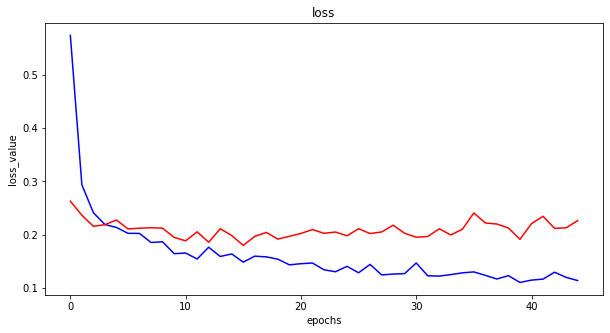

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(model_main.history.history['loss'],color='b',label='Training loss')
plt.plot(model_main.history.history['val_loss'],color='r',label='Validation loss')
plt.xlabel("epochs")
plt.ylabel("loss_value")
plt.title("loss")

Text(0.5, 1.0, 'accuracy graph')

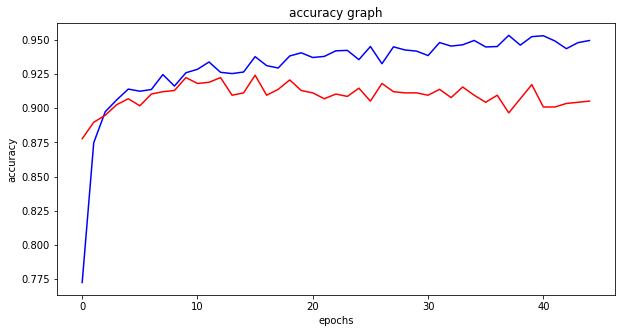

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(model_main.history.history['sparse_categorical_accuracy'],color='b',label='Training accuracy')     #accuracy
plt.plot(model_main.history.history['val_sparse_categorical_accuracy'],color='r',label='Validation accsuracy') #val_accuracy
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("accuracy graph")

In [ ]:
import shutil
shutil.move("/content/RESNET50_PLANT_DISEASE.h5", "/content/drive/MyDrive/skin_plant_disease/model_checkpoint")

'/content/drive/MyDrive/skin_plant_disease/model_checkpoint/RESNET50_PLANT_DISEASE.h5'

In [ ]:
from keras.models import load_model
model = load_model('RESNET50_PLANT_DISEASE.h5')

In [ ]:
lst = ['benign','Blight','Common_Rust','Healthy','malignant']
lst.sort()
lst

['Blight', 'Common_Rust', 'Healthy', 'benign', 'malignant']

25
1/1 [==============================] - 1s 1s/step


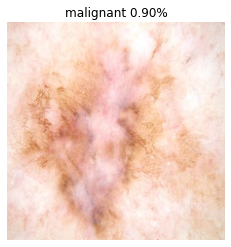

1/1 [==============================] - 0s 24ms/step


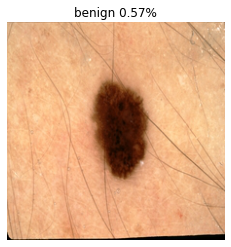

1/1 [==============================] - 0s 23ms/step


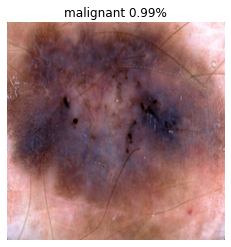

1/1 [==============================] - 0s 25ms/step


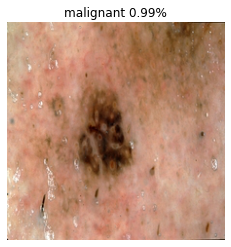

1/1 [==============================] - 0s 20ms/step


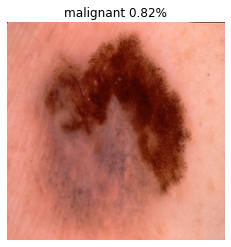

1/1 [==============================] - 0s 21ms/step


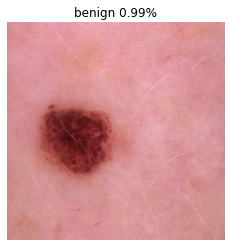

1/1 [==============================] - 0s 23ms/step


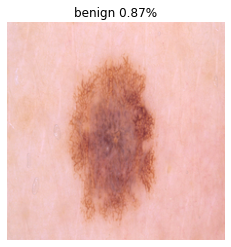

1/1 [==============================] - 0s 21ms/step


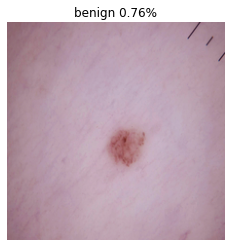

1/1 [==============================] - 0s 22ms/step


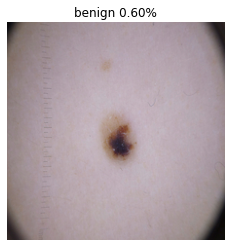

1/1 [==============================] - 0s 37ms/step


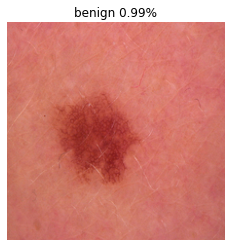

1/1 [==============================] - 0s 22ms/step


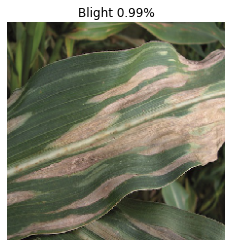

1/1 [==============================] - 0s 22ms/step


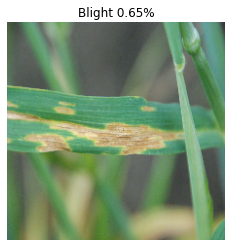

1/1 [==============================] - 0s 21ms/step


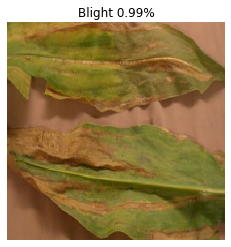

1/1 [==============================] - 0s 22ms/step


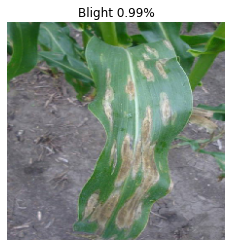

1/1 [==============================] - 0s 21ms/step


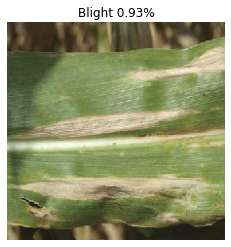

1/1 [==============================] - 0s 24ms/step


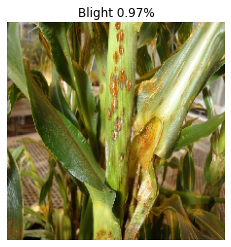

1/1 [==============================] - 0s 23ms/step


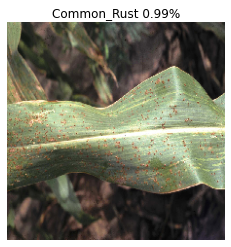

1/1 [==============================] - 0s 21ms/step


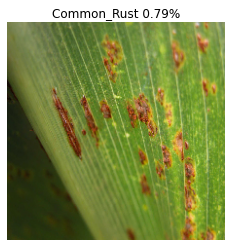

1/1 [==============================] - 0s 25ms/step


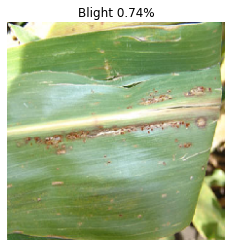

1/1 [==============================] - 0s 23ms/step


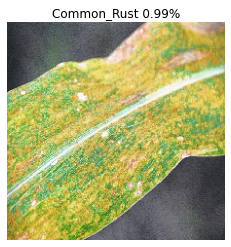

1/1 [==============================] - 0s 22ms/step


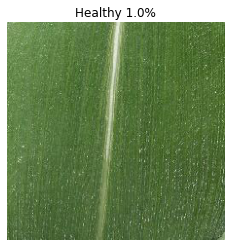

1/1 [==============================] - 0s 46ms/step


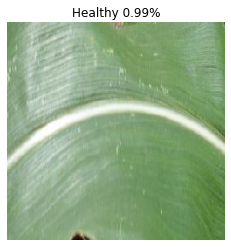

1/1 [==============================] - 0s 23ms/step


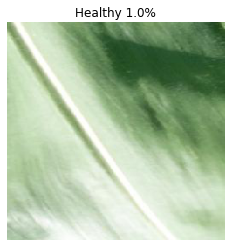

1/1 [==============================] - 0s 23ms/step


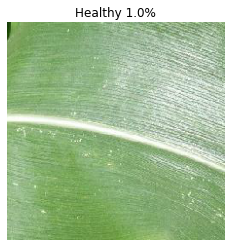

1/1 [==============================] - 0s 26ms/step


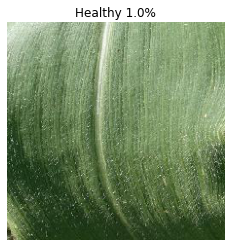

In [ ]:
Li = ['Blight', 'Common_Rust', 'Healthy', 'benign', 'malignant']

# predicting an image
import os
import matplotlib.pyplot as plt
from keras.preprocessing import image
import numpy as np
directory="/content/skin_plant_disease/test"
files = [os.path.join(directory,p) for p in sorted(os.listdir(directory))]
total_test_img = len(files)
print(len(files))

for i in range(total_test_img):
    image_path = files[i]
    new_img =keras.utils.load_img(image_path, target_size=(224, 224))
    img = keras.utils.img_to_array(new_img)
    img = np.expand_dims(img, axis=0)
    # img = img/255
    prediction = model.predict(img)
    probabilty = prediction.flatten() ##
    max_prob = probabilty.max()
    index=prediction.argmax(axis=-1)[0]
    class_name = Li[index]
    #ploting image with predicted class name        
    plt.figure(figsize = (4,4))
    plt.imshow(new_img)
    plt.axis('off')
    plt.title(class_name+" "+ str(max_prob)[0:4]+"%")
    plt.show()

33
1/1 [==============================] - 0s 24ms/step


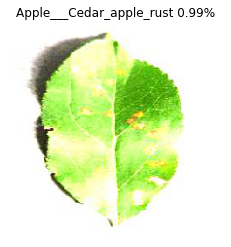

1/1 [==============================] - 0s 24ms/step


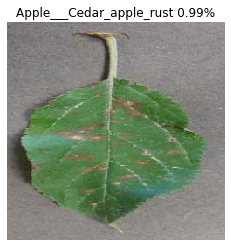

1/1 [==============================] - 0s 24ms/step


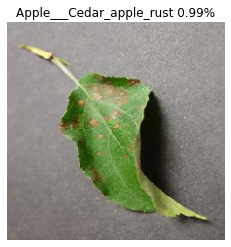

1/1 [==============================] - 0s 22ms/step


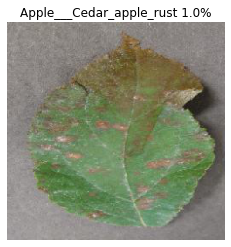

1/1 [==============================] - 0s 22ms/step


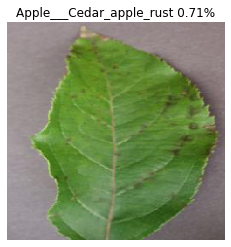

1/1 [==============================] - 0s 24ms/step


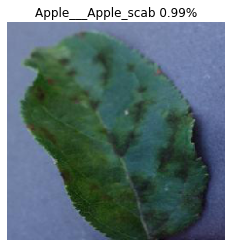

1/1 [==============================] - 0s 23ms/step


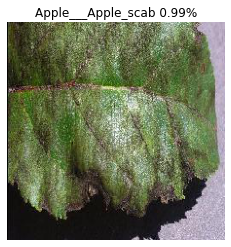

1/1 [==============================] - 0s 24ms/step


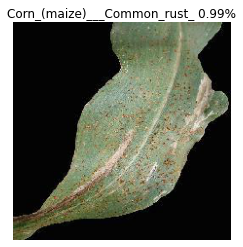

1/1 [==============================] - 0s 24ms/step


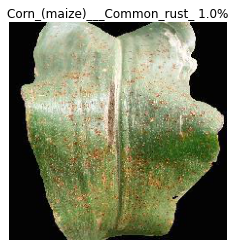

1/1 [==============================] - 0s 30ms/step


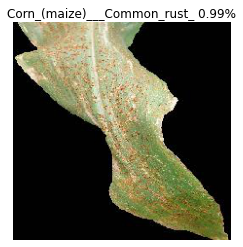

1/1 [==============================] - 0s 23ms/step


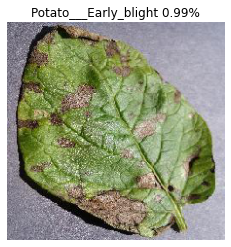

1/1 [==============================] - 0s 23ms/step


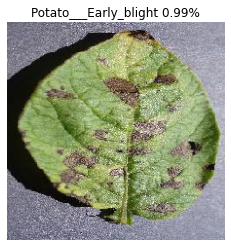

1/1 [==============================] - 0s 23ms/step


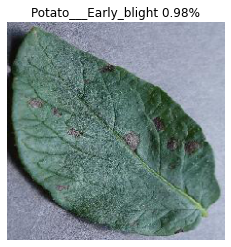

1/1 [==============================] - 0s 30ms/step


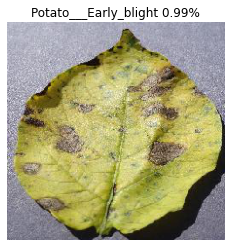

1/1 [==============================] - 0s 21ms/step


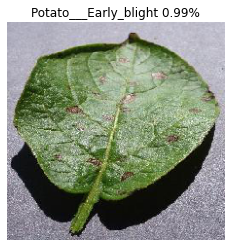

1/1 [==============================] - 0s 23ms/step


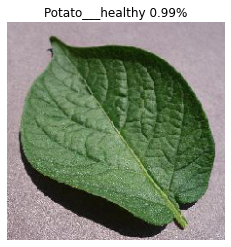

1/1 [==============================] - 0s 22ms/step


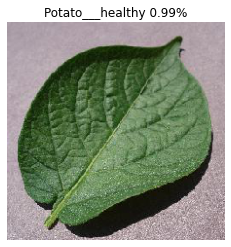

1/1 [==============================] - 0s 27ms/step


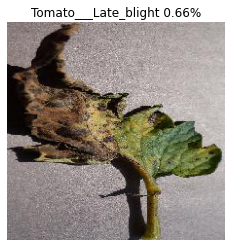

1/1 [==============================] - 0s 32ms/step


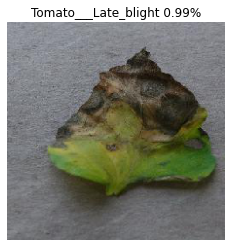

1/1 [==============================] - 0s 22ms/step


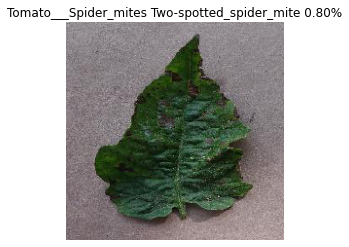

1/1 [==============================] - 0s 25ms/step


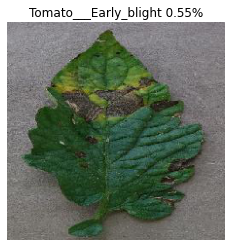

1/1 [==============================] - 0s 34ms/step


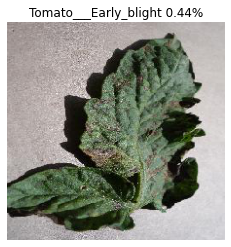

1/1 [==============================] - 0s 33ms/step


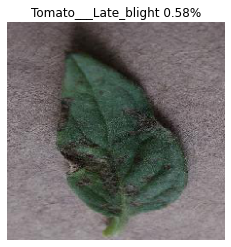

1/1 [==============================] - 0s 34ms/step


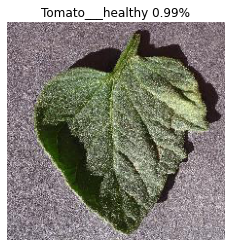

1/1 [==============================] - 0s 27ms/step


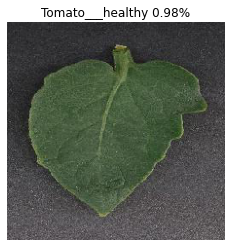

1/1 [==============================] - 0s 44ms/step


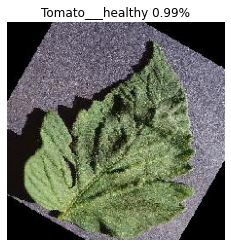

1/1 [==============================] - 0s 27ms/step


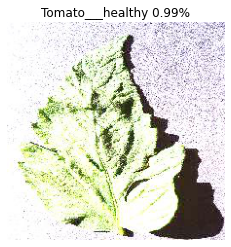

1/1 [==============================] - 0s 31ms/step


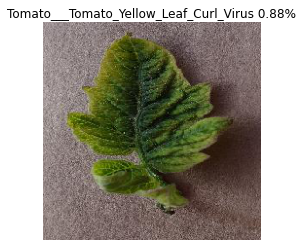

1/1 [==============================] - 0s 34ms/step


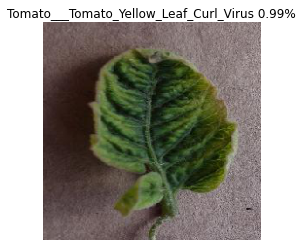

1/1 [==============================] - 0s 31ms/step


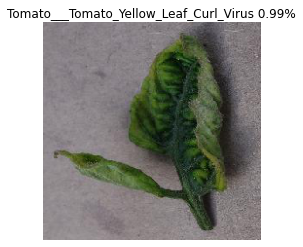

1/1 [==============================] - 0s 33ms/step


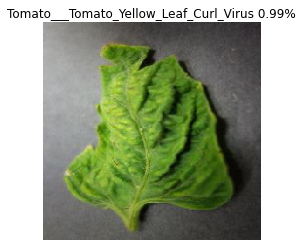

1/1 [==============================] - 0s 28ms/step


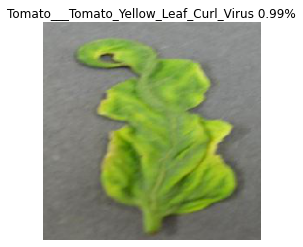

1/1 [==============================] - 0s 29ms/step


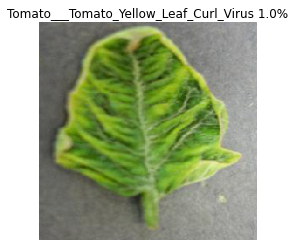

In [ ]:
Li = ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 
      'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 
      'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 
      'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 
      'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 
      'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch',
      'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 
      'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite',
      'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']

# predicting an image
import os
import matplotlib.pyplot as plt
from keras.preprocessing import image
import numpy as np
directory="/content/new-plant-diseases-dataset/test/test"
files = [os.path.join(directory,p) for p in sorted(os.listdir(directory))]
total_test_img = len(files)
print(len(files))

for i in range(total_test_img):
    image_path = files[i]
    new_img =keras.utils.load_img(image_path, target_size=(224, 224))
    img = keras.utils.img_to_array(new_img)
    img = np.expand_dims(img, axis=0)
    # img = img/255
    prediction = model.predict(img)
    probabilty = prediction.flatten() ##
    max_prob = probabilty.max()
    index=prediction.argmax(axis=-1)[0]
    class_name = Li[index]
    #ploting image with predicted class name        
    plt.figure(figsize = (4,4))
    plt.imshow(new_img)
    plt.axis('off')
    plt.title(class_name+" "+ str(max_prob)[0:4]+"%")
    plt.show()

In [ ]:
a="32233"
b=a[::-1]
b

'33223'

In [ ]:
class EMP:
  def __init__(self):
    pass
  def salary(self,salary_per_month,)
